<h1>CNN + MLPNN model</h1>

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [14]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [31]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))
                
        model.add(Dense(4))
        model.add(Activation('softmax'))   

        if len(conv_layers_filters_array) == 0 and len(dense_layers_unit_array) > 0 : 
            model.build(input_shape=(None, number_of_features))
        else:
            model.build(input_shape=(None, number_of_features, 1)) 

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [35]:
def train_and_test_model(train_dataset, validate_dataset, x_train, test_dataset,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))
    


In [17]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [18]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train_for_mlpnn = X_train.copy()
X_validate_for_mlpnn = X_validate.copy()
X_test_for_mlpnn = X_test.copy()

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_train_for_mlpnn, y_train))
validate_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_validate_for_mlpnn, y_validate))
test_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_test_for_mlpnn, y_test))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset_for_mlpnn.with_options(options)
validate_dataset_for_mlpnn.with_options(options)
test_dataset_for_mlpnn.with_options(options)

train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 30
train_dataset_for_mlpnn = train_dataset_for_mlpnn.batch(batch_size)
validate_dataset_for_mlpnn = validate_dataset_for_mlpnn.batch(batch_size)
test_dataset_for_mlpnn = test_dataset_for_mlpnn.batch(batch_size)

train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


<h4>MLPNN base model</h4>
Use MLPNN only best model as baseline.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:64
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0
startWithBatchNormalized: True
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738)              14952     
_________________________________________________________________
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
fc_1 (Dense)                 (None, 64)                32832     
_____________________________________________

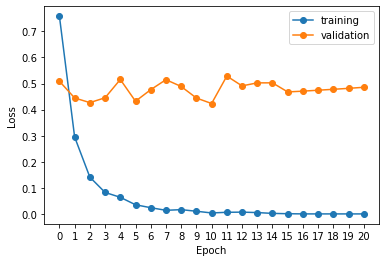

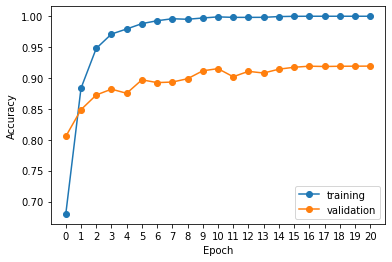

268/268 [==============================] - 2s 6ms/step - loss: 0.5017 - accuracy: 0.9174 - precision: 0.9184 - recall: 0.9170

Test Acc. 91.74%
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1978
           1       0.92      0.92      0.92      1957
           2       0.95      0.94      0.94      2069
           3       0.91      0.90      0.90      2011

   micro avg       0.92      0.92      0.92      8015
   macro avg       0.92      0.92      0.92      8015
weighted avg       0.92      0.92      0.92      8015
 samples avg       0.92      0.92      0.92      8015

Confusion matrix
[[1796   86   33   63]
 [  94 1808   14   41]
 [  37   13 1943   76]
 [  92   48   65 1806]]


In [38]:
train_and_test_model(train_dataset_for_mlpnn, validate_dataset_for_mlpnn, X_train_for_mlpnn, 
                     test_dataset_for_mlpnn,
                     save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,64], learningRate=0.001,
                     startWithBatchNormalized=True, optimizer="Adam",
                     activation="relu"
                    )

<h4>MLPNN base model + 1 CNN layer</h4>
Add 1 CNN layer to our best MLPNN model to get a feel.

<h3>Perform hyperparam tuning using the base MLPNN + CNN layer(s)</h3>


In [41]:

number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dense_layers_unit_array_size', min_value=1, max_value=3, step=1)
    dense_layers_unit_array = []
    
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(hp.Int('dl_units_'+str(i), 
                                              min_value=64, max_value=640, step=64))
    
    conv_layers_filters_array=[]
    conv_kernel_size_array=[]
    conv_strides_array=[]
    
    conv_layers_filters_array_size = 2
    for i in range(conv_layers_filters_array_size):
        conv_layers_filters_array.append(hp.Int('conv_layers_filters_'+str(i), 
                                                min_value=10, max_value=70, step=10))
        conv_kernel_size_array.append(hp.Int('conv_kernel_'+str(i), 
                                                min_value=2, max_value=5, step=1))
        conv_strides_array.append(hp.Int('conv_stride_'+str(i), 
                                          min_value=1, max_value=3, step=1))
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.001, 0.005, 0.01, 0.05]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.7, step=0.1),
                startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),      
                optimizer=hp.Choice("optimizer", values=["Adam", "SGD"]),   
                conv_layers_filters_array=conv_layers_filters_array,
                conv_kernel_size_array=conv_kernel_size_array,
                conv_strides_array=conv_strides_array     
                       )
    
    return model
                        
             

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')

epochs = 40

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")
print("dense_layers_unit_array_size:",best_hps.get('dl_unit_array_size'))
try:
    print("dl_units_0:",best_hps.get('dl_units_0'))
except:
    print("no dense layer 0")
try:
    print("dl_units_1:",best_hps.get('dl_units_1'))
except:
    print("no dense layer 1")
try:
    print("dl_units_2:",best_hps.get('dl_units_2'))
except:
    print("no dense layer 2")    

print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))
print("conv_layers_filters_array_size:",best_hps.get('conv_layers_filters_array_size'))

try:
    print("conv_layers_filters_0:",best_hps.get('conv_layers_filters_0'))
    print("conv_kernel_0:",best_hps.get('conv_kernel_0'))
    print("conv_stride_0:",best_hps.get('conv_stride_0'))
except:
    print("no conv layer 0")
    
try:
    print("conv_layers_filters_1:",best_hps.get('conv_layers_filters_1'))
    print("conv_kernel_1:",best_hps.get('conv_kernel_1'))
    print("conv_stride_1:",best_hps.get('conv_stride_1'))
except:
    print("no conv layer 1")
    
try:
    print("conv_layers_filters_2:",best_hps.get('conv_layers_filters_2'))
    print("conv_kernel_2:",best_hps.get('conv_kernel_2'))
    print("conv_stride_2:",best_hps.get('conv_stride_2'))    
except:
    print("no conv layer 2")
    
try:
    print("conv_layers_filters_0:",best_hps.get('conv_layers_filters_3'))
    print("conv_kernel_3:",best_hps.get('conv_kernel_3'))
    print("conv_stride_3:",best_hps.get('conv_stride_3'))    
except:
    print("no conv layer 3")    

print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

print("Confusion matrix")
print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


Trial 14 Complete [00h 00m 23s]
val_accuracy: 0.30895933508872986

Best val_accuracy So Far: 0.6076865196228027
Total elapsed time: 00h 00m 23s

Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
dense_layers_un...|1                 |3                 
dl_units          |256               |576               
conv_layers_fil...|60                |40                
conv_kernel_0     |4                 |2                 
conv_stride_0     |3                 |1                 
conv_layers_fil...|10                |10                
conv_kernel_1     |3                 |4                 
conv_stride_1     |3                 |2                 
learningRate      |0.001             |0.001             
activation        |relu              |relu              
isBatchNormalized |1                 |0                 
dropOutRate       |0.5               |0.4               
startWithBatchN...|1                 |1                 
optimizer         |Adam       

<h1>Random runs to get a feel of the hyperparameters</h1>

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:10
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None, 3738, 10)          40        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 1869, 10)          0  

Epoch 28/40
752/752 [==============================] - 9s 11ms/step - loss: 0.4031 - accuracy: 0.8425 - precision: 0.8940 - recall: 0.7805 - val_loss: 0.5901 - val_accuracy: 0.7919 - val_precision: 0.8559 - val_recall: 0.7025
Epoch 29/40
752/752 [==============================] - 9s 11ms/step - loss: 0.3872 - accuracy: 0.8491 - precision: 0.8991 - recall: 0.7869 - val_loss: 0.5844 - val_accuracy: 0.7940 - val_precision: 0.8609 - val_recall: 0.7010
Epoch 30/40
752/752 [==============================] - 9s 11ms/step - loss: 0.3766 - accuracy: 0.8521 - precision: 0.9044 - recall: 0.7984 - val_loss: 0.5845 - val_accuracy: 0.7941 - val_precision: 0.8651 - val_recall: 0.7048
Epoch 31/40
752/752 [==============================] - 9s 11ms/step - loss: 0.3692 - accuracy: 0.8524 - precision: 0.9018 - recall: 0.8020 - val_loss: 0.5857 - val_accuracy: 0.7939 - val_precision: 0.8593 - val_recall: 0.7086
Epoch 32/40
752/752 [==============================] - 9s 11ms/step - loss: 0.3625 - accuracy: 0

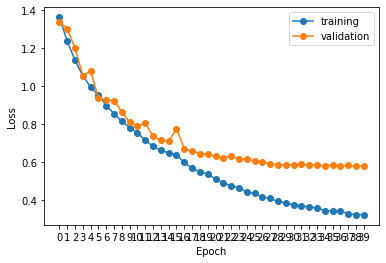

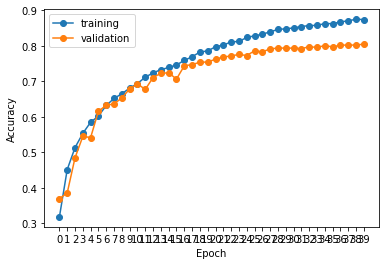

251/251 [==============================] - 2s 6ms/step - loss: 0.6205 - accuracy: 0.8055 - precision: 0.8604 - recall: 0.7424

Test Acc. 80.55%
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1978
           1       0.81      0.79      0.80      1957
           2       0.83      0.87      0.85      2069
           3       0.79      0.78      0.78      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [24]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     #1 conv layer
                     conv_layers_filters_array=[10],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:5
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None, 3738, 5)           20        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 1869, 5)           0   

Epoch 28/40
752/752 [==============================] - 8s 10ms/step - loss: 0.4411 - accuracy: 0.8280 - precision: 0.8867 - recall: 0.7612 - val_loss: 0.6497 - val_accuracy: 0.7677 - val_precision: 0.8415 - val_recall: 0.6762
Epoch 29/40
752/752 [==============================] - 8s 11ms/step - loss: 0.4200 - accuracy: 0.8289 - precision: 0.8908 - recall: 0.7647 - val_loss: 0.6551 - val_accuracy: 0.7680 - val_precision: 0.8381 - val_recall: 0.6836
Epoch 30/40
752/752 [==============================] - 8s 10ms/step - loss: 0.4077 - accuracy: 0.8383 - precision: 0.8960 - recall: 0.7774 - val_loss: 0.6421 - val_accuracy: 0.7750 - val_precision: 0.8392 - val_recall: 0.6929
Epoch 31/40
752/752 [==============================] - 8s 11ms/step - loss: 0.3979 - accuracy: 0.8424 - precision: 0.8962 - recall: 0.7824 - val_loss: 0.6470 - val_accuracy: 0.7761 - val_precision: 0.8424 - val_recall: 0.6943
Epoch 32/40
752/752 [==============================] - 8s 11ms/step - loss: 0.3811 - accuracy: 0

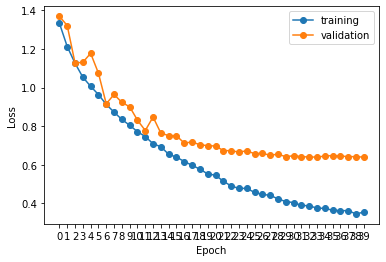

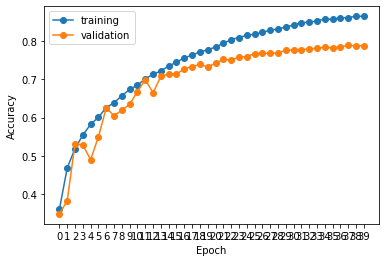

251/251 [==============================] - 2s 6ms/step - loss: 0.6942 - accuracy: 0.7895 - precision: 0.8444 - recall: 0.7193

Test Acc. 78.95%
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1978
           1       0.79      0.77      0.78      1957
           2       0.83      0.85      0.84      2069
           3       0.76      0.77      0.77      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.79      0.79      0.79      8015
weighted avg       0.79      0.79      0.79      8015
 samples avg       0.79      0.79      0.79      8015



TypeError: Singleton array 2 cannot be considered a valid collection.

In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     #1 conv layer
                     conv_layers_filters_array=[5],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None, 3738, 100)         400       
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 1869, 100)         0 

Epoch 28/40
752/752 [==============================] - 22s 29ms/step - loss: 0.4218 - accuracy: 0.8279 - precision: 0.8903 - recall: 0.7678 - val_loss: 0.5856 - val_accuracy: 0.7844 - val_precision: 0.8564 - val_recall: 0.6948
Epoch 29/40
752/752 [==============================] - 22s 29ms/step - loss: 0.4054 - accuracy: 0.8370 - precision: 0.8970 - recall: 0.7764 - val_loss: 0.5843 - val_accuracy: 0.7869 - val_precision: 0.8587 - val_recall: 0.7021
Epoch 30/40
752/752 [==============================] - 22s 29ms/step - loss: 0.3963 - accuracy: 0.8383 - precision: 0.8970 - recall: 0.7783 - val_loss: 0.5770 - val_accuracy: 0.7919 - val_precision: 0.8600 - val_recall: 0.7105
Epoch 31/40
752/752 [==============================] - 21s 28ms/step - loss: 0.3817 - accuracy: 0.8499 - precision: 0.9029 - recall: 0.7939 - val_loss: 0.5795 - val_accuracy: 0.7894 - val_precision: 0.8558 - val_recall: 0.7141
Epoch 32/40
752/752 [==============================] - 22s 29ms/step - loss: 0.3726 - accura

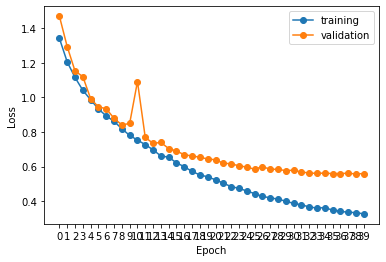

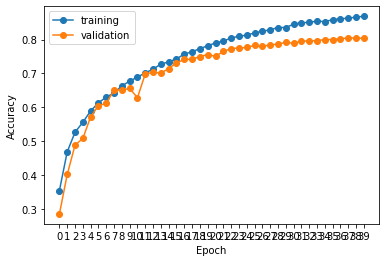

251/251 [==============================] - 2s 8ms/step - loss: 0.5729 - accuracy: 0.8081 - precision: 0.8651 - recall: 0.7427

Test Acc. 80.81%
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1978
           1       0.82      0.78      0.80      1957
           2       0.85      0.86      0.85      2069
           3       0.78      0.79      0.79      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



TypeError: Singleton array 2 cannot be considered a valid collection.

In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     #1 conv layer
                     conv_layers_filters_array=[100],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

In [7]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     #1 conv layer
                     conv_layers_filters_array=[1000],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1000
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/t

ResourceExhaustedError: OOM when allocating tensor with shape[1869000,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 1
conv_layer_filters[0]; unit:151
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None, 3738, 151)         604       
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 1869, 151)         0 

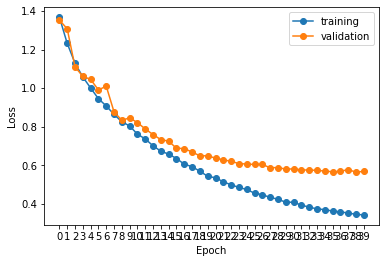

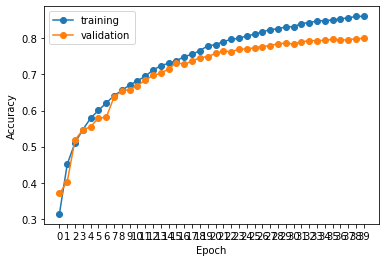

251/251 [==============================] - 2s 8ms/step - loss: 0.5796 - accuracy: 0.7996 - precision: 0.8567 - recall: 0.7354

Test Acc. 79.96%
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1978
           1       0.79      0.79      0.79      1957
           2       0.83      0.86      0.85      2069
           3       0.77      0.78      0.78      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015

Confusion matrix
[[1503  231   79  165]
 [ 176 1552   90  139]
 [  69   66 1777  157]
 [ 138  112  184 1577]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [30]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     #1 conv layer
                     conv_layers_filters_array=[151],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

How about 2 Conv layers, 50 units each. Compare this with just one Conv layer with 100 units.
Test accuracy improved from 80% to 88.57%.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 2
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:50
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None, 3738, 50)          200       
______________________________________________

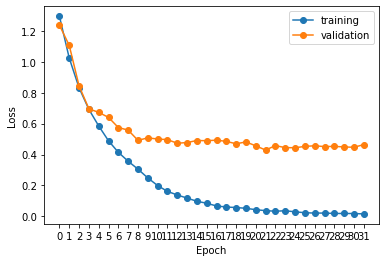

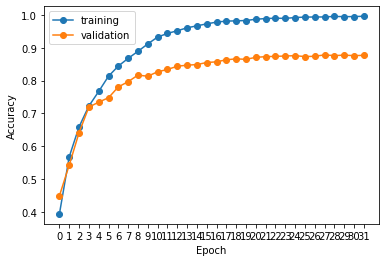

251/251 [==============================] - 2s 7ms/step - loss: 0.4841 - accuracy: 0.8857 - precision: 0.8897 - recall: 0.8818

Test Acc. 88.57%
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1978
           1       0.89      0.88      0.88      1957
           2       0.93      0.90      0.91      2069
           3       0.86      0.89      0.87      2011

   micro avg       0.89      0.89      0.89      8015
   macro avg       0.89      0.89      0.89      8015
weighted avg       0.89      0.89      0.89      8015
 samples avg       0.89      0.89      0.89      8015

Confusion matrix
[[1738  104   36  100]
 [ 124 1719   35   79]
 [  40   49 1858  122]
 [ 101   58   68 1784]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=float32))

In [33]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

How about 3 Conv layers, 33 units each. Compare this with 2 Conv layer with 50 units each.
Test accuracy drops a little..

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:33
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:33
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:33
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None

Epoch 26/40
752/752 [==============================] - 10s 13ms/step - loss: 0.0442 - accuracy: 0.9874 - precision: 0.9895 - recall: 0.9862 - val_loss: 0.5630 - val_accuracy: 0.8514 - val_precision: 0.8567 - val_recall: 0.8454
Epoch 27/40
752/752 [==============================] - 10s 13ms/step - loss: 0.0390 - accuracy: 0.9871 - precision: 0.9886 - recall: 0.9861 - val_loss: 0.5544 - val_accuracy: 0.8600 - val_precision: 0.8656 - val_recall: 0.8544
Epoch 28/40
752/752 [==============================] - 10s 13ms/step - loss: 0.0306 - accuracy: 0.9906 - precision: 0.9915 - recall: 0.9900 - val_loss: 0.5572 - val_accuracy: 0.8564 - val_precision: 0.8638 - val_recall: 0.8514
Epoch 00028: early stopping


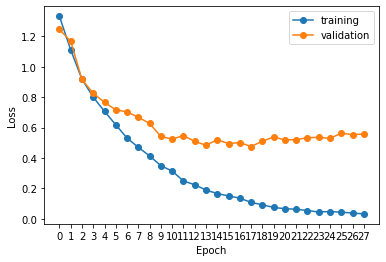

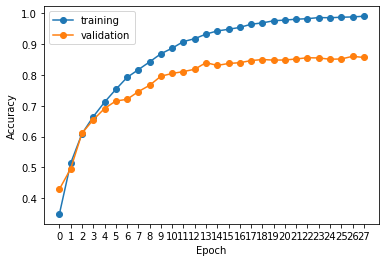

251/251 [==============================] - 2s 6ms/step - loss: 0.6159 - accuracy: 0.8601 - precision: 0.8672 - recall: 0.8549

Test Acc. 86.01%
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1978
           1       0.85      0.87      0.86      1957
           2       0.91      0.88      0.89      2069
           3       0.85      0.85      0.85      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.86      0.86      0.86      8015
weighted avg       0.86      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1665  155   48  110]
 [ 153 1697   39   68]
 [  72   57 1828  112]
 [ 115   91  101 1704]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=float32))

In [34]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[33,33,33],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

How about 3 conv layers, 50 units each. Compare to 3 conv layers with 33 units each, and 2 conv layers with 50 each.

Is better than 3 layers 33 each, but worse than 2 layers 50 each.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:50
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:50
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None

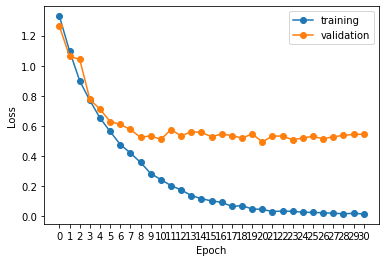

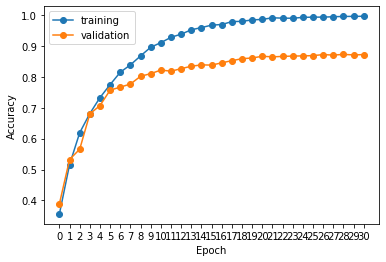

251/251 [==============================] - 2s 7ms/step - loss: 0.5679 - accuracy: 0.8762 - precision: 0.8813 - recall: 0.8726

Test Acc. 87.62%
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1978
           1       0.89      0.87      0.88      1957
           2       0.91      0.91      0.91      2069
           3       0.86      0.87      0.86      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015

Confusion matrix
[[1706  115   49  108]
 [ 142 1700   37   78]
 [  52   34 1876  107]
 [ 121   59   90 1741]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [35]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50,50],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

How about 3 layers 22 each?
Worse then 3 layers 33/50

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:20
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:20
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:20
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None

Epoch 26/40
752/752 [==============================] - 9s 12ms/step - loss: 0.0759 - accuracy: 0.9741 - precision: 0.9773 - recall: 0.9710 - val_loss: 0.5454 - val_accuracy: 0.8433 - val_precision: 0.8553 - val_recall: 0.8347
Epoch 00026: early stopping


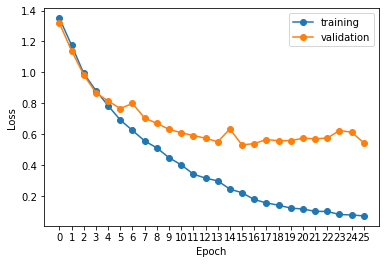

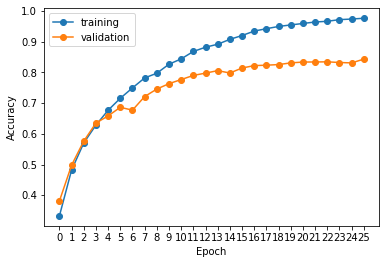

251/251 [==============================] - 2s 6ms/step - loss: 0.5855 - accuracy: 0.8485 - precision: 0.8578 - recall: 0.8408

Test Acc. 84.85%
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1978
           1       0.83      0.86      0.85      1957
           2       0.89      0.88      0.89      2069
           3       0.84      0.82      0.83      2011

   micro avg       0.85      0.85      0.85      8015
   macro avg       0.85      0.85      0.85      8015
weighted avg       0.85      0.85      0.85      8015
 samples avg       0.85      0.85      0.85      8015

Confusion matrix
[[1651  157   63  107]
 [ 146 1684   41   86]
 [  61   69 1825  114]
 [ 135  113  122 1641]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [36]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[20,20,20],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

How about 3 layers 70 each?
better than 3 layers 50 each. 88.47% -> 87.62%.
Try to increase more for 3 layers..

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:70
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:70
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:70
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (None

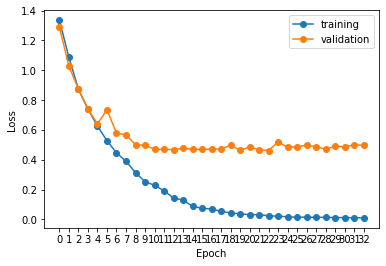

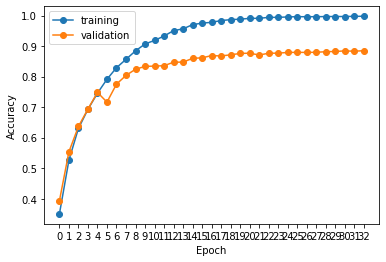

251/251 [==============================] - 2s 7ms/step - loss: 0.4962 - accuracy: 0.8847 - precision: 0.8899 - recall: 0.8825

Test Acc. 88.47%
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1978
           1       0.88      0.89      0.88      1957
           2       0.92      0.90      0.91      2069
           3       0.87      0.87      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015

Confusion matrix
[[1725  120   51   82]
 [ 126 1740   25   66]
 [  48   37 1869  115]
 [  91   82   81 1757]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [37]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[70,70,70],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

3 layers 100 each?
still a bit better.
88.82 -> 88.47%

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (N

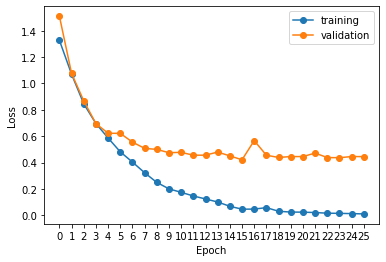

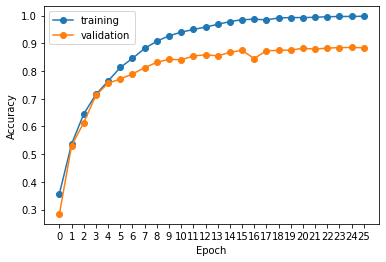

251/251 [==============================] - 2s 8ms/step - loss: 0.4413 - accuracy: 0.8882 - precision: 0.8919 - recall: 0.8847

Test Acc. 88.82%
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1978
           1       0.88      0.90      0.89      1957
           2       0.93      0.90      0.91      2069
           3       0.86      0.89      0.87      2011

   micro avg       0.89      0.89      0.89      8015
   macro avg       0.89      0.89      0.89      8015
weighted avg       0.89      0.89      0.89      8015
 samples avg       0.89      0.89      0.89      8015

Confusion matrix
[[1701  128   42  107]
 [ 103 1760   23   71]
 [  42   38 1868  121]
 [  72   66   83 1790]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [38]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

3 layers 120 each?
Perform worse than 3 layers 100 each.
88.68 -> 88.82 % in 3 layers 100 each.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:120
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:120
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:120
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (N

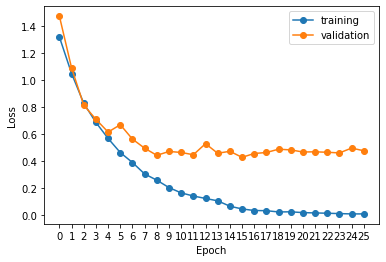

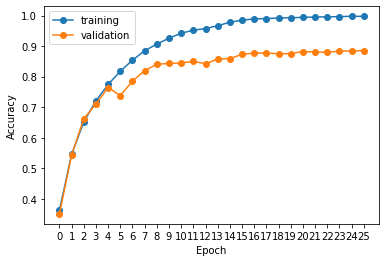

251/251 [==============================] - 2s 8ms/step - loss: 0.4598 - accuracy: 0.8868 - precision: 0.8924 - recall: 0.8838

Test Acc. 88.68%
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1978
           1       0.88      0.90      0.89      1957
           2       0.91      0.91      0.91      2069
           3       0.87      0.87      0.87      2011

   micro avg       0.89      0.89      0.89      8015
   macro avg       0.89      0.89      0.89      8015
weighted avg       0.89      0.89      0.89      8015
 samples avg       0.89      0.89      0.89      8015

Confusion matrix
[[1710  127   44   97]
 [  95 1758   36   68]
 [  45   37 1883  104]
 [  81   75   98 1757]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [39]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[120,120,120],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

Start trying out 4 conv layers. Lets do 4 layers, 75 each.
only 86.68%

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 4
conv_layer_filters[0]; unit:75
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:75
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:75
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
conv_layer_filters[3]; unit:75
conv_kernel[3]; unit:3
conv_strides[3]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
______________________

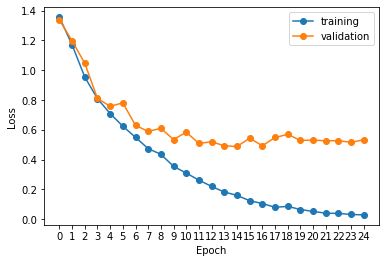

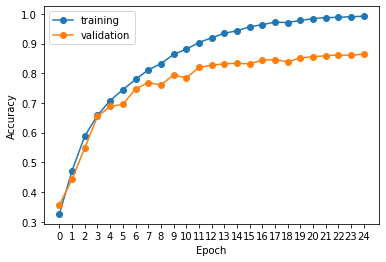

251/251 [==============================] - 2s 7ms/step - loss: 0.5757 - accuracy: 0.8656 - precision: 0.8699 - recall: 0.8621

Test Acc. 86.56%
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1978
           1       0.86      0.87      0.87      1957
           2       0.89      0.91      0.90      2069
           3       0.85      0.86      0.85      2011

   micro avg       0.87      0.87      0.87      8015
   macro avg       0.87      0.87      0.87      8015
weighted avg       0.87      0.87      0.87      8015
 samples avg       0.87      0.87      0.87      8015

Confusion matrix
[[1626  171   65  116]
 [ 114 1711   44   88]
 [  46   33 1879  111]
 [  96   73  120 1722]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [40]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[75,75,75,75],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

4 conv layers, 50 each.
dropping accuracy

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 4
conv_layer_filters[0]; unit:50
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:50
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:50
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
conv_layer_filters[3]; unit:50
conv_kernel[3]; unit:3
conv_strides[3]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
______________________

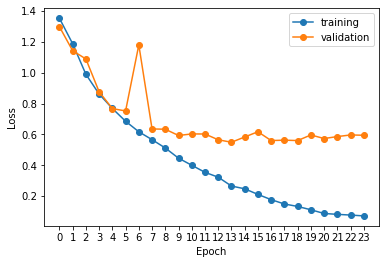

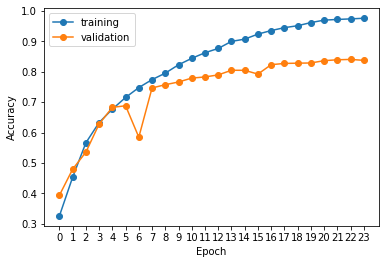

251/251 [==============================] - 3s 7ms/step - loss: 0.6067 - accuracy: 0.8399 - precision: 0.8487 - recall: 0.8326

Test Acc. 83.99%
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1978
           1       0.85      0.85      0.85      1957
           2       0.89      0.87      0.88      2069
           3       0.78      0.85      0.82      2011

   micro avg       0.84      0.84      0.84      8015
   macro avg       0.84      0.84      0.84      8015
weighted avg       0.84      0.84      0.84      8015
 samples avg       0.84      0.84      0.84      8015

Confusion matrix
[[1559  155   66  198]
 [ 142 1658   36  121]
 [  68   43 1798  160]
 [  94   87  113 1717]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [41]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50,50,50],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

4 conv layers, 100 each

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 4
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
conv_layer_filters[3]; unit:100
conv_kernel[3]; unit:3
conv_strides[3]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
__________________

752/752 [==============================] - 12s 16ms/step - loss: 0.0280 - accuracy: 0.9918 - precision: 0.9925 - recall: 0.9911 - val_loss: 0.5760 - val_accuracy: 0.8571 - val_precision: 0.8616 - val_recall: 0.8529
Epoch 25/40
752/752 [==============================] - 12s 16ms/step - loss: 0.0251 - accuracy: 0.9939 - precision: 0.9943 - recall: 0.9936 - val_loss: 0.5955 - val_accuracy: 0.8575 - val_precision: 0.8627 - val_recall: 0.8553
Epoch 00025: early stopping


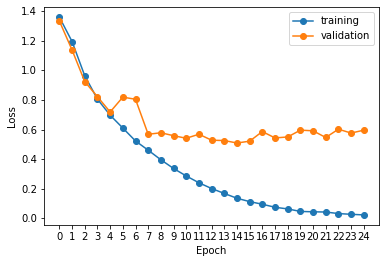

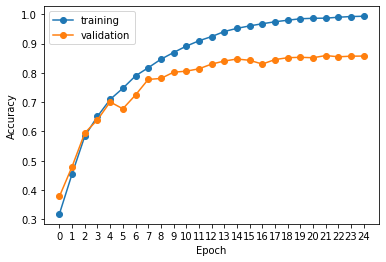

251/251 [==============================] - 2s 8ms/step - loss: 0.5976 - accuracy: 0.8640 - precision: 0.8691 - recall: 0.8615

Test Acc. 86.40%
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1978
           1       0.84      0.88      0.86      1957
           2       0.92      0.89      0.90      2069
           3       0.84      0.86      0.85      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.86      0.86      0.86      8015
weighted avg       0.86      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1628  182   57  111]
 [ 120 1728   25   84]
 [  50   52 1839  128]
 [ 112   84   85 1730]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [42]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100,100],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

4 conv layers, 120 each. see if it can do better than 3 conv layers 120 each.
actually is doing worse than 4 layers 100 each..

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 4
conv_layer_filters[0]; unit:120
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:120
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:120
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
conv_layer_filters[3]; unit:120
conv_kernel[3]; unit:3
conv_strides[3]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
__________________

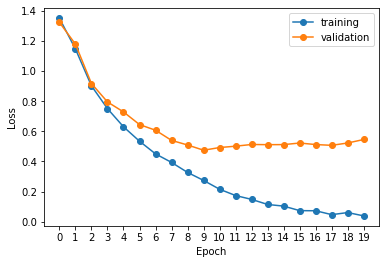

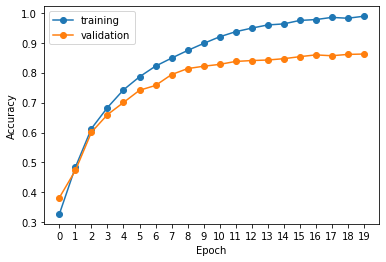

251/251 [==============================] - 2s 8ms/step - loss: 0.5668 - accuracy: 0.8610 - precision: 0.8656 - recall: 0.8574

Test Acc. 86.10%
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1978
           1       0.85      0.88      0.87      1957
           2       0.94      0.86      0.90      2069
           3       0.79      0.91      0.84      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.87      0.86      0.86      8015
weighted avg       0.87      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1584  181   40  173]
 [ 101 1715   22  119]
 [  44   45 1778  202]
 [  64   65   58 1824]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [43]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[120,120,120,120],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

try 3 layers, 100,70,40? comparing to the best 100,100,100 see how this goes?

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:70
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:40
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (Non

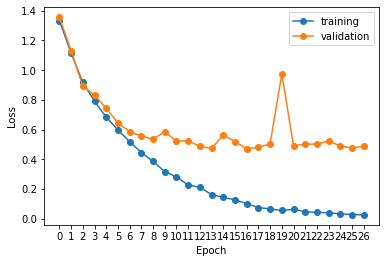

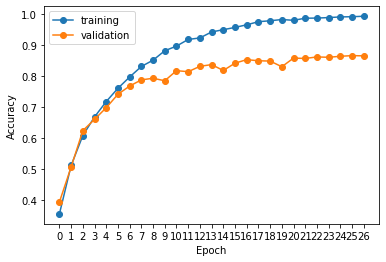

251/251 [==============================] - 2s 7ms/step - loss: 0.4946 - accuracy: 0.8736 - precision: 0.8790 - recall: 0.8699

Test Acc. 87.36%
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1978
           1       0.88      0.88      0.88      1957
           2       0.91      0.90      0.91      2069
           3       0.86      0.85      0.86      2011

   micro avg       0.87      0.87      0.87      8015
   macro avg       0.87      0.87      0.87      8015
weighted avg       0.87      0.87      0.87      8015
 samples avg       0.87      0.87      0.87      8015

Confusion matrix
[[1710  127   40  101]
 [ 129 1717   36   75]
 [  66   41 1866   96]
 [ 123   77  102 1709]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]], dtype=float32))

In [44]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,70,40],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

Back to the best 3 conv layers 100 units each. Try adding another Dense layer.
Not much improvement.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.2
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0

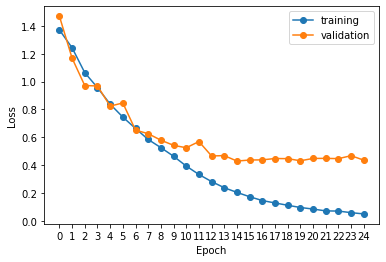

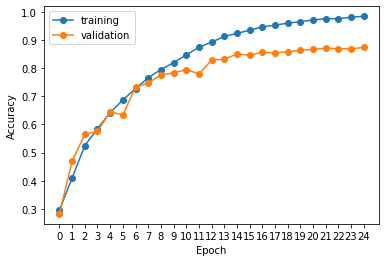

251/251 [==============================] - 2s 8ms/step - loss: 0.4318 - accuracy: 0.8826 - precision: 0.8888 - recall: 0.8780

Test Acc. 88.26%
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1978
           1       0.89      0.88      0.89      1957
           2       0.93      0.90      0.92      2069
           3       0.85      0.87      0.86      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015

Confusion matrix
[[1723  111   32  112]
 [ 128 1729   21   79]
 [  51   40 1864  114]
 [ 107   61   85 1758]]


(       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
 4644             0            0            1            0
 12965            0            1            0            0
 9468             1            0            0            0
 19462            1            0            0            0
 39479            0            0            1            0
 ...            ...          ...          ...          ...
 34014            0            0            0            1
 18494            0            0            1            0
 24169            0            1            0            0
 26155            0            0            1            0
 37218            0            0            1            0
 
 [8015 rows x 4 columns],
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=float32))

In [54]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.2,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

3 layers, longer patience?

epoch: 40 ; epoch_denominator: 10.0
patience: 20 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.2
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
conv_0 (Conv1D)              (N

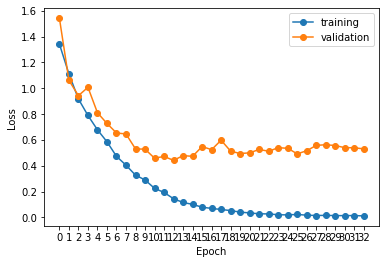

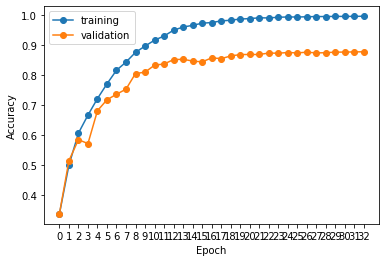

251/251 [==============================] - 2s 8ms/step - loss: 0.5396 - accuracy: 0.8801 - precision: 0.8835 - recall: 0.8774

Test Acc. 88.01%
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1978
           1       0.89      0.88      0.88      1957
           2       0.91      0.91      0.91      2069
           3       0.86      0.87      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015

Confusion matrix
[[1712  116   57   93]
 [ 133 1714   32   78]
 [  47   30 1874  118]
 [  94   67   96 1754]]


In [60]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.2,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     patience=20
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1920,1920], learningRate=0.2, optimizer="SGD",
                     startWithBatchNormalized=True,
                     conv_layers_filters_array=[96,32,32],
                    conv_kernel_size_array=[3,3,3],
                    conv_strides_array=[1,1,1]
                    )